# Blackbird Force Estimation

The blackbird position estimation is currently taken from the camera system at ~360 Hz. Using the position information, this notebook will look at various ways to numerically estimate the velocity and acceleration along the flight test.


In [1]:
import sys
import os
sys.path.append(os.path.abspath('../functions'))
import read_blackbird_dataset as rbd

test_df = rbd.read_blackbird_test('figure8', 'Constant', 0.5)

In [2]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 216365 entries, 1526617312016142000 to 1526617526753759000
Data columns (total 37 columns):
PWM1                              39823 non-null float64
PWM2                              39823 non-null float64
PWM3                              39823 non-null float64
PWM4                              39823 non-null float64
angular_velocity_covariance       21298 non-null object
ax_[m/s2]                         21298 non-null float64
ay_[m/s2]                         21298 non-null float64
az_[m/s2]                         21298 non-null float64
linear_acceleration_covariance    21298 non-null object
omegax_[dps]                      21298 non-null float64
omegay_[dps]                      21298 non-null float64
omegaz_[dps]                      21298 non-null float64
orientation_covariance            21298 non-null object
pitch_[rad]                       77286 non-null float64
pitch_ref_[rad]                   38130 non-null float64
px_[m]

In [3]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd

rbts2s = 10 ** -9
tvec = (test_df.index - test_df.index[0])*rbts2s
tvec = tvec.astype('float')

fig, axis = plt.subplots(3,1)
fig.set_size_inches(9,6)
axis[0].plot(tvec, test_df['px_[m]'], color='r')
axis[1].plot(tvec, test_df['py_[m]'], color='g')
axis[2].plot(tvec, test_df['pz_[m]'], color='b')

plt.show()

<IPython.core.display.Javascript object>

## Numerical differentiation

One dimensional numerical differention uses a set of weights $W$ and a set of input points $X$ to estimate the n$^{th}$ derivative of a at point $x_i$. The method behind this technique uses a Taylor series approximation around $x_i$ such that 

$$ f(x) = f(x_i) + f'(x_i)(x - x_i) + \frac{1}{2}f''(x_i) (x - x_i)^2 + ...  $$

### NUMPY

The python library numpy as a built in gradient estimatator which mostly uses a second order central difference scheme:

$$ \hat{f}^{(1)}_i \approx \frac{h^2_s f(x_i + h_d) + (h^2_d - h^2_s)f(x_i) - h^2_d f(x_i - h_s)}{h_s h_d (h_d + h_s)} $$

Under assumption that the interval is evenly spaced, the estimation simplifies to:

$$ \hat{f}^{(1)}_i \approx \frac{f(x_{i+1}) - f(x_{i-1})}{2h} $$

In [4]:
# Numpy second order central difference
import numpy as np

dt = 1.0/360.0

px = test_df['px_[m]'].values
py = test_df['py_[m]'].values
pz = test_df['pz_[m]'].values

vx = np.gradient(px, tvec)
vy = np.gradient(py, tvec)
vz = np.gradient(pz, tvec)

vxhat = np.gradient(px, dt)
vyhat = np.gradient(py, dt)
vzhat = np.gradient(pz, dt)

discrepancy_x = vx - vxhat
discrepancy_y = vy - vyhat
discrepancy_z = vz - vzhat

In [5]:
fig, axis = plt.subplots(3,2)

axis[0][0].plot(tvec, vx, color='r')
axis[1][0].plot(tvec, vy, color='g')
axis[2][0].plot(tvec, vz, color='b')

axis[0][1].plot(tvec, discrepancy_x, color='r')
axis[1][1].plot(tvec, discrepancy_y, color='g')
axis[2][1].plot(tvec, discrepancy_z, color='b')

plt.show()

<IPython.core.display.Javascript object>

In [6]:
# Numpy second order central difference
# This will worsen errors
axg = np.gradient(vx, tvec)
ayg = np.gradient(vy, tvec)
azg = np.gradient(vz, tvec)

In [7]:
fig, axis = plt.subplots(3,1)

axis[0].plot(tvec, axg, color='r')
axis[1].plot(tvec, ayg, color='g')
axis[2].plot(tvec, azg, color='b')

plt.show()

<IPython.core.display.Javascript object>

### Arbitrary Numerical Derivative

While the velocity estimates using numpy seemed to do a decent job at the approximating, the numerical errors introduced by a repeated gradient application are simply too noisey. Instead an arbitary python function is written below which allows for non-uniform intervals. The general thoughts behind this method is using a Taylor Series approximation of the state vector about $x_i$:

$$ f(x) = \sum_{n=0}^\infty \frac{1}{n!}f^{(n)}(x_i) \cdot (x - x_i)^n $$

If we gather the collection of input points $X = \{x_i\}$ as well as the output points $F = \{f(x_i)\}$ and are trying to determine $\frac{d^n f}{dx^n} $ at the point $a$ then use the set of weights $W = \{w_i\}$ that correspond to $X$ and to get an approximation of $\frac{d^n f}{dx^n}$ by the following:

$$ \frac{d^n f}{dx^n}\Big|_{a} = \sum_{x_i, w_i \in X, W} w_i \cdot f(x_i) = \sum_{x_i, w_i \in X, W} w_i \cdot \left(\sum_{m=0}^\infty \frac{1}{m!}f^{(m)}(a) \cdot (x_i - a)^m \right) $$

The weights need to be choosen in such a way such that for $n = m$, the resulting $\sum_{x_i, w_i} \frac{w_i}{n!} (x_i - a)^n$ is 1 but 0 for $n \neq m$. Hence the weights are found by the following matrix equation were $h_i = x_i - a$.
.

$$ \begin{bmatrix} 0 \\ 0 \\ \vdots \\ 0 \\ 1 \\ 0 \\ \vdots \\ 0 \\ 0 \end{bmatrix} 
= \begin{bmatrix} 
1 & \dots & 1 & \dots & 1 \\ 
\vdots & \ddots &  &  & \vdots \\
\frac{h_0^n}{n!} &  & \ddots &  & \frac{h_m^n}{n!} \\ 
\vdots &  &  & \ddots  & \vdots \\
\frac{h_0^m}{m!} & \dots & \frac{h_n^m}{m!} & \dots & \frac{h_m^m}{m!} \\ 
\end{bmatrix} 
\begin{bmatrix} w_0 \\ w_1 \\ \vdots \\ w_{n-1} \\ w_{n} \\ w_{n+1} \\ \vdots \\ w_{m-1} \\ w_{m} \end{bmatrix} $$

In [8]:
# Creating an arbitrarily nth derivative with mth ordered numerical estimator:

import numpy as np
import math

def get_weights(n, h):
    #Preallocations
    m = h.shape[0]
    w = np.zeros((m,1))
    w[n] = 1.0

    # A(h) * w = [0,...,0,1,0,...,0]^T
    A = np.zeros((m,m))
    for i in range(m):
        for j in range(m):
            A[i,j] = (h[j][0] ** i)/float(math.factorial(i))
    return np.matmul(np.linalg.inv(A), w)
    
def nth_numerical_derivative(f, x, n=1, order=1, method='central'):
    """
    Summary: Finds the nth derivative of the state vector f along the input vector x with an order of m. Does either forward,
    backwards, or central methods for the majority of the vector with backwards to the end of the vector
    
    Parameters:
        f      = history vector of f(x_i)
        x      = history vector of x_i which is strictly monotonically increasing
        n      = nth order derivative
        order  = order of accuracy, which is used to determine the number of required points
        method = {'central', 'forward', 'backward'}
    
    Results:
        dndxn = history vector of the numerical nth order
    """
    
    #Preallocations
    m = x.shape[0]
    n_pts = n + order
    
    #check to make sure enough points for order
    if m < n_pts:
        error("Not enough points!")
    
    dndxn = np.zeros((m,1))
    
    if method == 'central':
        l_offset = int((n_pts - 1)/2)
        u_offset = n_pts - 1 - l_offset
        #print("(%i, %i)" % (l_offset, u_offset))
    elif method == 'forward':
        l_offset = n_pts - 1
        u_offset = 0
    elif method == 'backward':
        l_offset = 0
        u_offset = n_pts - 1
    else:
        error("Method must be in ['central', 'forward', 'backward']")
    
    # Iterate through the history vectors
    for i in range(m):
        if i < n_pts:
            h       = x[:n_pts] - x[i]
            f_local = f[:n_pts]
        elif i < (m - n_pts):
            h       = x[(i - l_offset):(i + u_offset + 1)] - x[i]
            f_local = f[(i - l_offset):(i + u_offset + 1)]
        else:
            h       = x[-n_pts:] - x[i]
            f_local = f[-n_pts:]
        h.reshape((n_pts,1))
        w = get_weights(n, h)
        dndxn[i] = sum(w*f_local)[0]

    return dndxn


In [9]:
print(get_weights(2, np.array([[0], [1.], [-1.]])))

[[-2.]
 [ 1.]
 [ 1.]]


In [10]:
#Testing above function
n = 10
x = np.linspace(-10, 10, num=n).reshape((n,1))
f = 0.1*(x ** 3)
f1 = 0.3 *(x ** 2)
f1 = 0.6 *(x ** 1)

#First Derivative
f1_n_f = nth_numerical_derivative(f, x, n=1, order=1, method='forward')
f1_n_b = nth_numerical_derivative(f, x, n=1, order=1, method='backward')
f1_n_c = nth_numerical_derivative(f, x, n=1, order=2, method='central')
#Second Derivative
f2_n_f = nth_numerical_derivative(f, x, n=2, order=1, method='forward')
f2_n_b = nth_numerical_derivative(f, x, n=2, order=1, method='backward')
f2_n_c = nth_numerical_derivative(f, x, n=2, order=1, method='central')

In [11]:
fig, axis = plt.subplots(2,1)

lf = axis[0].plot(x,f1_n_f, label='Forward')
lb = axis[0].plot(x,f1_n_b, label='Backward')
lc = axis[0].plot(x,f1_n_c, label='Central')

axis[0].legend()

for ddf in [f2_n_f, f2_n_b, f2_n_c]:
    axis[1].plot(x,ddf)

plt.show()

<IPython.core.display.Javascript object>

In [12]:
#Testing with noise
n = 100
x = np.linspace(-10, 10, num=n).reshape((n,1))
f = 0.1*(x ** 3) + .1*np.random.randn(n).reshape((n,1))
f1 = 0.3 *(x ** 2)
f1 = 0.6 *(x ** 1)

#First Derivative
f1_n_f = nth_numerical_derivative(f, x, n=1, order=3, method='forward')
f1_n_b = nth_numerical_derivative(f, x, n=1, order=3, method='backward')
f1_n_c = nth_numerical_derivative(f, x, n=1, order=2, method='central')
#Second Derivative
f2_n_f = nth_numerical_derivative(f, x, n=2, order=3, method='forward')
f2_n_b = nth_numerical_derivative(f, x, n=2, order=3, method='backward')
f2_n_c = nth_numerical_derivative(f, x, n=2, order=2, method='central')

fig, axis = plt.subplots(2,1)

for df in [f1_n_f, f1_n_b, f1_n_c]:
    axis[0].plot(x,df)
for ddf in [f2_n_f, f2_n_b, f2_n_c]:
    axis[1].plot(x,ddf)

plt.show()

<IPython.core.display.Javascript object>

In [13]:
#Testing On Flight Test Data

print(px.shape)
print(tvec.shape)

npts = px.shape[0]
tvec = np.array(tvec).reshape((npts,1))
ax_num_diff_c = nth_numerical_derivative(px.reshape((npts,1)), tvec, n=2)
ay_num_diff_c = nth_numerical_derivative(py.reshape((npts,1)), tvec, n=2)
az_num_diff_c = nth_numerical_derivative(pz.reshape((npts,1)), tvec, n=2)

(216365,)
(216365,)


In [14]:
fig, axis = plt.subplots(3,1)

axis[0].plot(tvec, ax_num_diff_c)
axis[1].plot(tvec, ay_num_diff_c)
axis[2].plot(tvec, az_num_diff_c)

plt.show()

<IPython.core.display.Javascript object>

## Savitzky-Golaz Filter
The [Savitzky-Golaz](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter) method fits the local noisy data with a local polynomial of degree n based on the local states $x_i$ and the local time $t_i$.

$$ \hat{p}(t) = \min_{p \in \mathbb{P}^n} \sum_{i=1}^m \left(x_i - p(t_i)\right)^2 $$

The benefit of this technique is that finding multiple ordered derivatives is fast. Consider the polinomial below:

$$ p_n (t) = a_0 + a_1 t + a_2 t^2 + ... + a_n t^n $$

The first and second derivates, which would be velocity and acceleration, are then fast to find as well as extrapolate.

$$ \frac{dp}{dt}|_{t=0} =  a_1 $$
$$ \frac{d^2 p}{dt^2}|_{t=0} =  2a_2 $$

Unlike the numerical methods used previously, the Savitzky-Golaz allows for the state being fitted to be noisey although the assumption is that the noise has a zero mean. A more general implementation is available through the [savgol_filter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html#scipy.signal.savgol_filter) function of the SciPy package. This implementation is limited in that it doesn't allow for multiple derivative outputs or uneven time interval spacing.

In [15]:
import math
import copy

def lsee_polynomial_extrapolate(tvec, x, tpred, m):
    """
    Uses the known points to fit a least squares polynomial and then extrapolates it to a predition interval
    """
    pn = tpred.shape[0] #number of prediction points
    dmdxm = np.zeros((pn, m+1))
    
    # Get coefficients
    X = np.outer(tvec, np.ones((m+1,))) # x (m+1)
        # creating rows of [t^0, t^1, ..., t^m]
    for j in range(m+1):
        X[:,j] = X[:,j] ** j
    Xt = np.transpose(X) #(m+1) x ws
    #Least squares solution (m+1)x1
    theta = np.matmul(np.linalg.inv(np.matmul(Xt,X)),
                      np.matmul(Xt, np.transpose(x)))
    
    #For prediction interval
    Xp  = np.outer(tpred, np.ones((m+1,)))
    for j in range(m+1):
        Xp[:,j] = Xp[:,j] ** j
    #Start populating the prediction
    diff_multiplier = list(range(1,m+1))
    for i in range(m+1):
        dmdxm[:,i] = np.matmul(Xp, theta)
        if i != m:
            Xp = Xp[:,:-1]
            theta = theta[1:]*diff_multiplier
            diff_multiplier = diff_multiplier[:-1]
    
    return dmdxm

# Creating function for arbitary polynomial fitting
def central_sg_filter(tvec, xvec, m=5, window=13):
    """
    Based off the Savitzky-Golay filter which uses a least-squares estimation to determine a local polynomial. 
    
    Parameters:
        tvec   = (n,) numpy array for time vector which is not uniform
        xvec   = (n,) numpy array of the noise time
        m      = mth order polynomial
        window = number of points to be looking at. Should be odd so that the smoothing is being done 
                [-(j-1)/2,...,-1,0,1,...,(j-1)/2]
    
    Output:
        dmdxm = (n,m+1) vector of 0th to mth derivatives
        
    Reference: https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter
    """
    
    #Initialize vectors
    n     = tvec.shape[0] #Length of x vector
    dmdxm = np.zeros((n,m+1)) #n x (m+1) matrix of the ith derivative
    hs    = int((window - 1)/2) #Half window size
    
    #Conversion between polynomial coefficients and the derivatives
    diff_multipliers = np.ones(m+1)
    mfact = math.factorial(m)
    for i in range(m+1):
        diff_multipliers[i] = math.factorial(i)
    
    #Middle sections (i.e. central estimations)
    for i in range(hs, n-hs):
        tlocal = tvec[i-hs:i+hs+1] - tvec[i]
        y      = xvec[i-hs:i+hs+1] #1 x ws
        X = np.outer(tlocal, np.ones((m+1,))) #ws x (m+1)
        # creating rows of [t^0, t^1, ..., t^m]
        for j in range(m+1):
            X[:,j] = X[:,j] ** j
        Xt = np.transpose(X) #(m+1) x ws
        
        try:
            #Least squares solution (m+1)x1
            XtXinv = np.linalg.inv(np.matmul(Xt,X))
            theta = np.matmul(XtXinv, np.matmul(Xt, np.transpose(y)))
        except np.linalg.LinAlgError as err:
            #exact solution
            X = X[:(m+1), :(m+2)] #Get a square matrix
            theta = np.matmul(np.linalg.inv(X), np.transpose(y[:(m+1)]))
            
        dmdxm[i,:] = np.transpose(theta)*diff_multipliers
    
    #Beginning and ending sections
    for (i0, index) in zip([hs, n-hs-1], [list(range(hs)), list(range(n-hs,n))]):
        
        t0        = tvec[i0] #zeroth time
        t_predict = tvec[index] - t0 # 1 x (window - 1)/2
        
        if i0 < n/2:
            i_train = list(range((i0+1),(i0+window+2)))
        else:
            i_train = list(range((i0-window-1),i0))
        
        t_train = tvec[i_train] - t0
        x_train = xvec[i_train]
        dmdxm[index,:] = lsee_polynomial_extrapolate(t_train, x_train, t_predict, m)
        
        """
        #dmdxm0 = dmdxm[i0,:] #all coefficients at the zeroth time
        #Trying to average the extrapolation coefficients
        if i0 > index[0]:
            dmdxm0 = copy.deepcopy(dmdxm[i0:(i0+hs+1),:])
            nt     = t0 - tvec[i0:(i0+hs+1)]
        else:
            dmdxm0 = copy.deepcopy(dmdxm[(i0-hs):(i0+1), :])
            nt     = t0 - tvec[(i0-hs):(i0+1)]
        print(dmdxm0)
        for i in range(1,m+1):
            for j in range(1,i+1):
                dmdxm0[:, -(i+1)] = dmdxm0[:, -(i+1)] + dmdxm0[:,-(i-j+1)]*(nt ** j)/math.factorial(j)
                print(nt)
                print(dmdxm0)
        dmdxm0 = np.mean(dmdxm0, axis=0)
        print(dmdxm0)
        
        #Estimate all derivatives in the end zones
        for i in range(m+1):
            if i == 0:
                dmdxm[index, -1] = dmdxm0[-1]
            #Should be a way to change this loop to matrix math with concatenation
            else:
                for j in range(i+1):
                    dmdxm[index, -i-1] = dmdxm[index, -i-1] +\
                                         dmdxm0[-(i-j+1)]*(tlocal ** j)/math.factorial(j)
        """
    return dmdxm

In [16]:
#Testing/debugging the filter above
# Simple case f(x) = a*x^3 + b*e where e ~ N(0,1)
n = 101
x = np.linspace(-10, 10, num=n)
f = 0.1*(x ** 3) + 1*np.random.randn(n)

dmdxm = central_sg_filter(x,f,m=3, window=7)

fig, axis = plt.subplots(1,1)
axis.plot(x,f)
axis.plot(x,dmdxm[:,0])

plt.show()

<IPython.core.display.Javascript object>

In [17]:
#Trying on sinosodal waves to determine behavior
# Simple case f(x) = a*x^3 + b*e where e ~ N(0,1)
n = 101
x = np.linspace(0, 2*np.pi, num=n)
f = np.sin(2*x) + .01*np.random.randn(n)

dmdxm = central_sg_filter(x,f,m=3, window=7)

fig, axis = plt.subplots(3,1)

axis[0].plot(x,f)
axis[0].plot(x,dmdxm[:,0])
axis[1].plot(x,2*np.cos(2*x))
axis[1].plot(x,dmdxm[:,1])
axis[2].plot(x,-4*np.sin(2*x))
axis[2].plot(x,dmdxm[:,2])

plt.show()

<IPython.core.display.Javascript object>

In [18]:
# Testing on x axis values
px_est = central_sg_filter(tvec, px, m=3, window=27)

fig, axis = plt.subplots(3,1)

axis[0].plot(tvec, px)
axis[0].plot(tvec, px_est[:,0])
axis[1].plot(tvec, vxhat)
axis[1].plot(tvec, px_est[:,1])
axis[1].set_ylim(-7.5, 7.5)
axis[2].plot(tvec, axg)
axis[2].plot(tvec, px_est[:,2])
axis[2].set_ylim(-100, 100)

plt.show()

<IPython.core.display.Javascript object>

## Force Validation

This section is to use the IMU readings to help validate the estimations coming from the camera system.

In [43]:
from quaternions import Rmatrix_from_quaternions as Rmatrix

n = len(px)

ax_I = px_est[:,2]
ay_I = px_est[:,2]
az_I = px_est[:,2] - 9.81 #includes gravitational offset

ax_B = np.zeros(n)
ay_B = np.zeros(n)
az_B = np.zeros(n)

qw = test_df['qw'].values
qx = test_df['qx'].values
qy = test_df['qy'].values
qz = test_df['qz'].values

In [44]:
for i in range(n):
    R = Rmatrix(qw[i], qx[i], qy[i], qz[i])
    acc_vec_I = np.array([[ax_I[i]], [ay_I[i]], [az_I[i]]])
    acc_vec_B = np.matmul(R, acc_vec_I).transpose()[0]

    ax_B[i] = acc_vec_B[0]
    ay_B[i] = acc_vec_B[1]
    az_B[i] = acc_vec_B[2]

In [45]:
#Getting IMU values

imu_ax = test_df['ax_[m/s2]'].dropna()

t_imu = (imu_ax.index - test_df.index[0])*rbts2s
t_imu = t_imu.astype('float')

imu_ax = test_df['ax_[m/s2]'].dropna().values
imu_ay = test_df['ay_[m/s2]'].dropna().values
imu_az = test_df['az_[m/s2]'].dropna().values

<IPython.core.display.Javascript object>


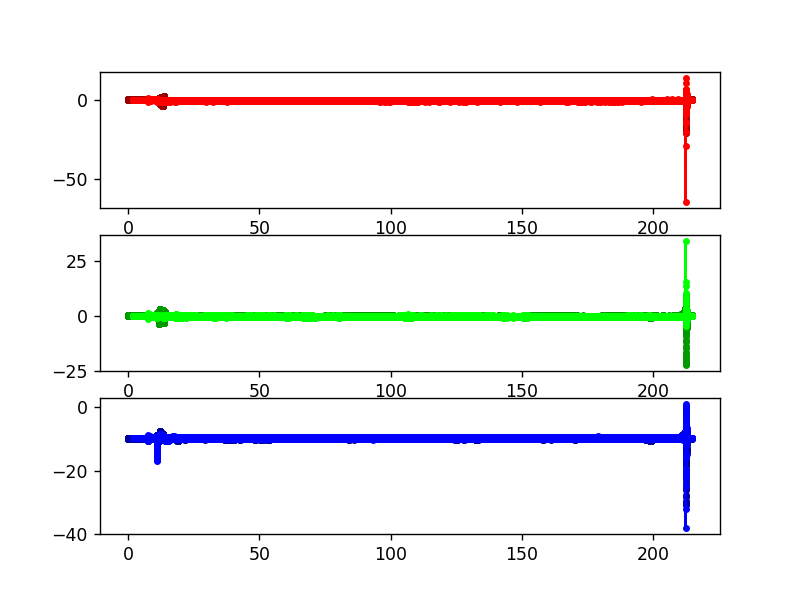

In [48]:
#Plotting
fig, axis = plt.subplots(3,1)

axis[0].plot(tvec, ax_B, color="#990000", linestyle=None, marker=".")
axis[0].plot(t_imu, -1.*imu_ay, color="#ff0000", linestyle=None, marker=".")
axis[1].plot(tvec, ay_B, color="#009900", linestyle=None, marker=".")
axis[1].plot(t_imu, imu_ax, color="#00ff00", linestyle=None, marker=".")
axis[2].plot(tvec, az_B, color="#000099", linestyle=None, marker=".")
axis[2].plot(t_imu, imu_az, color="#0000ff", linestyle=None, marker=".")

plt.show()